<a href="https://colab.research.google.com/github/nxxk23/PROJECT/blob/main/Model/SlopesSVR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 7.4 MB/s eta 0:00:00


In [3]:
!pip install scikeras

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor

from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import shap


In [5]:
bi3 = pd.read_excel('/content/drive/MyDrive/ckdresearch2023/Assign/Assign8 : SplitFold /binary_3_Group_5_Fold.xlsx')
bi3 = bi3.iloc[:, 1:]

In [6]:
bi3['NATNL'] = bi3['NATNL'].replace({0: 'Asian', 1: 'Asian', 3: 'Asian', 2: 'Non-Asian'})

In [7]:
bi3 = bi3.sort_values(['PatientUID', 'PatientVisitUID'])
bi3['TimeDiff'] = bi3.groupby('PatientUID')['LabCwhen'].diff().dt.days / 365
bi3['TimeDiff'] = bi3['TimeDiff'].fillna(0)

In [8]:
bi3['time_t1'] = pd.to_datetime(bi3['time_t1'])

In [9]:
columns_to_encode = ['VisitLocation', 'Group', 'NATNL']

# Apply label encoding using map
for column in columns_to_encode:
    encoding_map = {category: i for i, category in enumerate(bi3[column].unique())}
    bi3[column] = bi3[column].map(encoding_map)

In [10]:
def categorize_eGFR(eGFR_value):
    if eGFR_value >= 90:
        return 0
    elif eGFR_value >= 60:
        return 1
    elif eGFR_value >= 30:
        return 2
    elif eGFR_value >= 15:
        return 3
    else:
        return 4

bi3['Stage'] = bi3['eGFR_t1'].apply(categorize_eGFR)

# Split

In [11]:
X = bi3.drop(['Group','Stage','Slopes', 'PatientUID', 'PatientVisitUID', 'eGFR_t1', 'time_t1', 'StartDTTM', 'EndDttm',
               'LabCwhen', 'LabLocation', 'Fold'], axis=1)
y = bi3['Slopes']

In [12]:

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=None)
X = bi3.drop(['Slopes', 'PatientUID', 'PatientVisitUID', 'eGFR_t1', 'time_t1', 'StartDTTM', 'EndDttm',
               'LabCwhen', 'LabLocation', 'Fold'], axis=1)
y = bi3['Slopes']
all_folds = bi3['Fold'].unique()
X_train_scaled_list_bi3 = []
y_train_list_bi3 = []
X_test_scaled_list_bi3 = []
y_test_list_bi3 = []
for train_folds, test_fold in kf.split(all_folds):
    train_folds = all_folds[train_folds]
    val_fold = all_folds[test_fold][0]
    train_indices = bi3['Fold'].isin(train_folds)
    test_indices = bi3['Fold'] == val_fold
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_train_scaled_list_bi3.append(X_train_scaled)
    y_train_list_bi3.append(y_train)
    X_test_scaled_list_bi3.append(X_test_scaled)
    y_test_list_bi3.append(y_test)
for fold, (X_train_scaled_fold, y_train_fold, X_test_scaled_fold, y_test_fold, train_fold_indices) in enumerate(
        zip(X_train_scaled_list_bi3, y_train_list_bi3, X_test_scaled_list_bi3, y_test_list_bi3, kf.split(all_folds))
):
    train_folds, test_fold = train_fold_indices
    print(f"Training set size: {X_train_scaled_fold.shape}")
    print(f"Test set size: {X_test_scaled_fold.shape}")
    print(f"Folds in training set: {train_folds.tolist()}")
    print(f"Folds in test set: {test_fold}")
    print("---\n")


Training set size: (41978, 122)
Test set size: (10642, 122)
Folds in training set: [0, 1, 2, 3]
Folds in test set: [4]
---

Training set size: (42027, 122)
Test set size: (10593, 122)
Folds in training set: [0, 1, 3, 4]
Folds in test set: [2]
---

Training set size: (42274, 122)
Test set size: (10346, 122)
Folds in training set: [0, 2, 3, 4]
Folds in test set: [1]
---

Training set size: (42017, 122)
Test set size: (10603, 122)
Folds in training set: [1, 2, 3, 4]
Folds in test set: [0]
---

Training set size: (42184, 122)
Test set size: (10436, 122)
Folds in training set: [0, 1, 2, 4]
Folds in test set: [3]
---



#SVR

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import svm
from sklearn.svm import SVR

In [14]:
X = bi3.drop(['Group','Stage','Slopes', 'PatientUID', 'PatientVisitUID', 'eGFR_t1', 'time_t1', 'StartDTTM', 'EndDttm',
               'LabCwhen', 'LabLocation', 'Fold'], axis=1)
y = bi3['Slopes']

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(



Fold 1 Evaluation Metrics:
Mean Squared Error: 81.0682
Mean Absolute Error: 5.7999
R-squared: 0.1870


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(



Fold 2 Evaluation Metrics:
Mean Squared Error: 70.0536
Mean Absolute Error: 5.4745
R-squared: 0.2087


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(



Fold 3 Evaluation Metrics:
Mean Squared Error: 80.6821
Mean Absolute Error: 5.7161
R-squared: 0.1895


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(



Fold 4 Evaluation Metrics:
Mean Squared Error: 74.3175
Mean Absolute Error: 5.6468
R-squared: 0.2066


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(



Fold 5 Evaluation Metrics:
Mean Squared Error: 78.0421
Mean Absolute Error: 5.6168
R-squared: 0.1988
Mean Squared Error: 76.8327
Mean Absolute Error: 5.6508
Mean R-squared: 0.1981


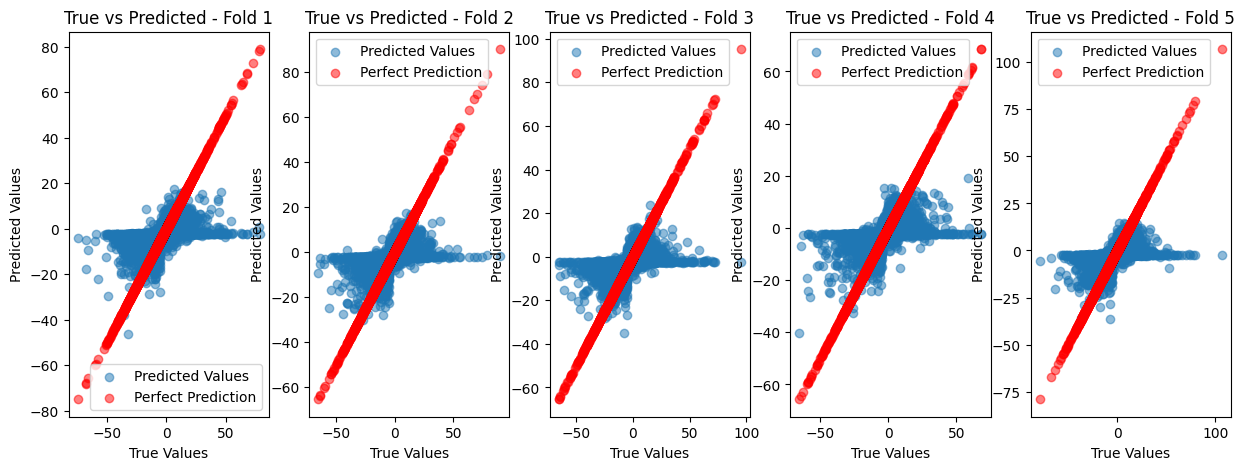

In [15]:
bi3_mse_scores = []
bi3_mae_scores = []
bi3_r2_scores = []

# Create subplots for each fold
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
axs = axs.ravel()

# Loop through each fold
for fold in range(5):
    # Fit the model on the training data for the current fold
    model_svr = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
    model_svr.fit(X_train_scaled_list_bi3[fold], y_train_list_bi3[fold])

    # Make predictions on the test data for the current fold
    y_pred = model_svr.predict(X_test_scaled_list_bi3[fold])

    # Plot original vs predicted values as data points
    axs[fold].scatter(y_test_list_bi3[fold], y_pred, label='Predicted Values', alpha=0.5)
    axs[fold].scatter(y_test_list_bi3[fold], y_test_list_bi3[fold], color='red', label='Perfect Prediction', alpha=0.5)
    axs[fold].set_title(f"True vs Predicted - Fold {fold + 1}")
    axs[fold].set_xlabel("True Values")
    axs[fold].set_ylabel("Predicted Values")
    axs[fold].legend()

    # Evaluate the model performance for the current fold
    mse = mean_squared_error(y_test_list_bi3[fold], y_pred)
    mae = mean_absolute_error(y_test_list_bi3[fold], y_pred)
    r2 = r2_score(y_test_list_bi3[fold], y_pred)

    # Print evaluation metrics for the current fold
    print(f"\nFold {fold + 1} Evaluation Metrics:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R-squared: {r2:.4f}")

    # Append scores to the lists for overall evaluation
    bi3_mse_scores.append(mse)
    bi3_mae_scores.append(mae)
    bi3_r2_scores.append(r2)

# Print mean scores across all folds
bi3_mean_mse = sum(bi3_mse_scores) / len(bi3_mse_scores)
bi3_mean_mae = sum(bi3_mae_scores) / len(bi3_mae_scores)
bi3_mean_r2 = sum(bi3_r2_scores) / len(bi3_r2_scores)

print(f"Mean Squared Error: {bi3_mean_mse:.4f}")
print(f"Mean Absolute Error: {bi3_mean_mae:.4f}")
print(f"Mean R-squared: {bi3_mean_r2:.4f}")

In [17]:
# Create a DataFrame to store performance metrics
performance_df = pd.DataFrame(columns=['Fold', 'MSE', 'MAE', 'R-squared'])

# Loop through each fold
for fold in range(5):
    # Evaluate the model performance for the current fold
    mse = bi3_mse_scores[fold]
    mae = bi3_mae_scores[fold]
    r2 = bi3_r2_scores[fold]

    # Append scores to the DataFrame
    performance_df = pd.concat([performance_df, pd.DataFrame({'Fold': [fold + 1], 'MSE': [mse], 'MAE': [mae], 'R-squared': [r2]})], ignore_index=True)

# Calculate mean scores across all folds
overall_svr = performance_df.mean().to_dict()
overall_svr['Fold'] = 'Overall'
performance_svr = pd.concat([performance_df, pd.DataFrame(overall_svr, index=[len(performance_df)])], ignore_index=True)

print("\nSupport Vector Regressor Performance:")
print(performance_svr)


Support Vector Regressor Performance:
      Fold        MSE       MAE  R-squared
0        1  81.068245  5.799895   0.186960
1        2  70.053600  5.474523   0.208716
2        3  80.682060  5.716148   0.189493
3        4  74.317501  5.646839   0.206604
4        5  78.042093  5.616791   0.198779
5  Overall  76.832700  5.650839   0.198110
